# Implementation of Logistic Regression
### 1. Import of data
### 2. Split the data into train, valid and test data
### 3. Application of Logistic Regression
### 4. Hyperparamter optimization with grid search

**1. Import of data**

In [0]:
import pandas as pd
import numpy as np

# Import train_test_split function
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Doc2vec
# CSVLInk = r'/content/drive/My Drive/Feature_generated_sets/doc2vec/Pretrained_withScore.csv'
# hotelData = pd.read_csv(CSVLInk)

# Bag of Words - TF / TF-IDF
CSVLInk = r'/content/drive/My Drive/Feature_generated_sets/BOW/tf_561-woerter.pkl'
# FastText
# CSVLInk = r'/content/drive/My Drive/Feature_generated_sets/fast_text/fast_text_nonswr.pkl'
hotelData =pd.DataFrame(np.load(CSVLInk,allow_pickle=True))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**2. Split the data into train, valid and test data**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train_test_valid_split(df,upsampling=True):
    train,test = train_test_split(df,test_size=0.3,stratify=df["Reviewer_Score"], random_state=42)
    test,valid = train_test_split(test,test_size=0.5,stratify=test["Reviewer_Score"], random_state=42)
    #In summary, the following split: 70% training, 15% validation, 15% testing

    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    if(upsampling): #Idea: reduce class 0 to the size of class 1, dupliate samples from class 2 to the size of class 1
        train_0 = train[train["Reviewer_Score"]==0].sample(frac=(counts_train[1]/counts_train[0]), random_state=42)
        train_1 = train[train["Reviewer_Score"]==1]
        train_2 = train[train["Reviewer_Score"]==2].sample(frac=(counts_train[1]/counts_train[2]),replace=True, random_state=42)
        train = train_0.append(train_1).append(train_2)
    unique, counts_train = np.unique(train["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts_train)
    #print(counts_train)
    
    unique, counts = np.unique(test["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    #print(counts)
    
    unique, counts = np.unique(valid["Reviewer_Score"], return_counts=True)
    plt.bar(unique, counts)
    #print(counts)

        

    plt.title('Class Frequency')
    plt.xlabel('Class')
    plt.ylabel('Frequency')

    #plt.show()
    
    return train,valid,test

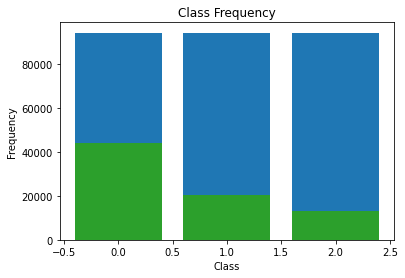

In [0]:
train, valid, test = train_test_valid_split(hotelData,upsampling=True)

y_train = train["Reviewer_Score"]
X_train = train.drop(["Reviewer_Score"], axis=1)

y_test = valid["Reviewer_Score"]
X_test = valid.drop(["Reviewer_Score"], axis=1)

y_testTEST = test["Reviewer_Score"]
X_testTEST = test.drop(["Reviewer_Score"], axis=1)

#To save Ram
train=0
valid=0
test=0
hotelData=0

**3. Application of Logistic Regression**

In [0]:
from sklearn.linear_model import LogisticRegression
firstTime = time.time()
lg_estimatorTest = LogisticRegression(random_state=0,n_jobs=-1)
lg_estimatorTest.fit(X_train, y_train)
predTest = lg_estimatorTest.predict(X_test)
print ("--- %s seconds ---" % round(time.time()-firstTime,4))

--- 136.9197 seconds ---


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print(f1_score(y_test, predTest, average='macro'))
print(accuracy_score(y_test, predTest))

0.588142535442712
0.6245653494654929


**4. Hyperparamter optimization with grid search**

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# Source : https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5 and sklearn site

firstTime = time.time()           
param_grid = [ 
{'penalty' : ['l1','l2'], 'solver' : ['liblinear','saga'],'C' : [100, 150, 200,300,500]},
    {'penalty' : ['none', 'l2'], 'solver' : ['newton-cg', 'lbfgs', 'sag'], 'C' : [100, 150, 200,300,500]}
    ,]
stratified_3_fold_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(lg_estimatorTest, param_grid, cv=stratified_3_fold_cv,
scoring='f1_macro', n_jobs = -1)  
grid_search.fit(X_train, y_train)
print ("--- %s seconds ---" % round(time.time()-firstTime,4))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


--- 4983.8427 seconds ---


In [0]:
# Print results
cvres = grid_search.cv_results_
for f1score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(f1score, params)
print("\n",grid_search.best_params_)

0.5551469292591672 {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.5672691412171263 {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.5551413651927689 {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.5673547578381379 {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.555118980606581 {'C': 150, 'penalty': 'l1', 'solver': 'liblinear'}
0.5672988350865262 {'C': 150, 'penalty': 'l1', 'solver': 'saga'}
0.5550989857432529 {'C': 150, 'penalty': 'l2', 'solver': 'liblinear'}
0.5673291474638033 {'C': 150, 'penalty': 'l2', 'solver': 'saga'}
0.5551641672428399 {'C': 200, 'penalty': 'l1', 'solver': 'liblinear'}
0.5673424385031381 {'C': 200, 'penalty': 'l1', 'solver': 'saga'}
0.5550938024214211 {'C': 200, 'penalty': 'l2', 'solver': 'liblinear'}
0.567328406844215 {'C': 200, 'penalty': 'l2', 'solver': 'saga'}
0.5551187398899836 {'C': 300, 'penalty': 'l1', 'solver': 'liblinear'}
0.5673291474638033 {'C': 300, 'penalty': 'l1', 'solver': 'saga'}
0.5550638898854919 {'C': 300, 'penalty': 'l2', 'solver': 